In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # train_data processing, CSV file I/O (e.g. pd.read_csv)

# Input train_data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# **Obtaining data**

In [2]:
# Importing required libraries
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option("display.max_columns", None) # to see all columns 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import learning_curve

from numpy.random import seed

In [3]:
import logging
import time
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)

warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

In [4]:
data = pd.read_csv("data/music_genre.csv")
data.shape

(50005, 18)

In [5]:
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.00000,Röyksopp,Röyksopp's Night Out,27.00000,0.00468,0.65200,-1.00000,0.94100,0.79200,A#,0.11500,-5.20100,Minor,0.07480,100.889,4-Apr,0.75900,Electronic
1,46652.00000,Thievery Corporation,The Shining Path,31.00000,0.01270,0.62200,218293.00000,0.89000,0.95000,D,0.12400,-7.04300,Minor,0.03000,115.00200000000001,4-Apr,0.53100,Electronic
2,30097.00000,Dillon Francis,Hurricane,28.00000,0.00306,0.62000,215613.00000,0.75500,0.01180,G#,0.53400,-4.61700,Major,0.03450,127.994,4-Apr,0.33300,Electronic
3,62177.00000,Dubloadz,Nitro,34.00000,0.02540,0.77400,166875.00000,0.70000,0.00253,C#,0.15700,-4.49800,Major,0.23900,128.014,4-Apr,0.27000,Electronic
4,24907.00000,What So Not,Divide & Conquer,32.00000,0.00465,0.63800,222369.00000,0.58700,0.90900,F#,0.15700,-6.26600,Major,0.04130,145.036,4-Apr,0.32300,Electronic


The obtained_data is irrelevant for the experiment

In [6]:
data = data.drop(['obtained_date','instance_id'],axis = 1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       50000 non-null  object 
 1   track_name        50000 non-null  object 
 2   popularity        50000 non-null  float64
 3   acousticness      50000 non-null  float64
 4   danceability      50000 non-null  float64
 5   duration_ms       50000 non-null  float64
 6   energy            50000 non-null  float64
 7   instrumentalness  50000 non-null  float64
 8   key               50000 non-null  object 
 9   liveness          50000 non-null  float64
 10  loudness          50000 non-null  float64
 11  mode              50000 non-null  object 
 12  speechiness       50000 non-null  float64
 13  tempo             50000 non-null  object 
 14  valence           50000 non-null  float64
 15  music_genre       50000 non-null  object 
dtypes: float64(10), object(6)
memory usage: 

We can see that the artist_name, track_name, key, mode, tempo, music_genre are not numeric data.

# Cleaning data

##### Let first check the Nan data.

In [8]:
print(pd.isnull(data).sum())

artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
valence             5
music_genre         5
dtype: int64


It seems that there are only a few columns contain null value. So we drop these columns.

In [9]:
data = data.dropna()
print(pd.isnull(data).sum())

artist_name         0
track_name          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
music_genre         0
dtype: int64


In [10]:
train_data = data.copy()
train_data_info = train_data[["artist_name", "track_name", "music_genre"]]
train_data = train_data.drop(["artist_name", "track_name", "music_genre"],axis = 1)

Columns key, mode, tempo still need to be converted to numerical data

## Covert Categorical variables to Numeric variable

In [11]:
train_data['mode'].value_counts()

Major    32099
Minor    17901
Name: mode, dtype: int64

In [12]:
mode_mapping = {'Major': 1, "Minor": 0}
train_data['mode'] = train_data['mode'].map(mode_mapping)

In [13]:
train_data['key'].value_counts()

G     5727
C     5522
C#    5405
D     5265
A     4825
F     4341
B     3789
E     3760
A#    3356
G#    3319
F#    3101
D#    1590
Name: key, dtype: int64

Covert note to number: https://en.wikipedia.org/wiki/Musical_note

In [14]:
key_mapping = {'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5, 'F#': 6, 'G': 7, 'A': 9, 'A#': 10, 'B': 11}
train_data['key'] = train_data['key'].map(key_mapping)

In [15]:
train_data['tempo'].value_counts()

?                     4980
140.007                 17
120.0                   17
100.00299999999999      16
100.014                 15
                      ... 
137.046                  1
136.378                  1
93.041                   1
113.98200000000001       1
99.20100000000001        1
Name: tempo, Length: 29394, dtype: int64

In [16]:
train_data['tempo'] = train_data['tempo'].replace('?',np.NaN)
train_data['tempo'] = train_data['tempo'].apply(pd.to_numeric)

# Rescaling the Features

For distance based algorithms like KNN, SVM and gradient descend based algorithms like neural network, it is better to use scaling as the magnitude can have a huge effect on the model's performance.
There are two ways of rescaling: standardization and normalization. We can see from the histogram that most data is not following gaussian distribution. So we decide to use normalization.

In [17]:
print(train_data.columns)

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence'],
      dtype='object')


In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# scaling columns with values beyond the range from 0 to 1

train_data_copy = train_data.copy(deep=True)

cols_out_of_range = train_data[train_data.columns].apply(lambda x: x is not str and x.min() < 0 or x.max() > 1)
# get the column names of the DataFrame as a list
col_names = train_data.columns.tolist()

# get a list of columns that have values out of range
cols_out_of_range_list = [col_name for col_name, out_of_range in zip(col_names, cols_out_of_range) if out_of_range]
cols_out_of_range_list

train_data[cols_out_of_range_list] = scaler.fit_transform(train_data[cols_out_of_range_list])
# train_data['loudness'] = minus_scaler.fit_transform(train_data['loudness'].values.reshape(-1,1))
train_data.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,-1.10800,0.00468,0.65200,-1.71953,0.94100,0.79200,1.37994,0.11500,0.63813,0,0.07480,-0.62216,0.75900
1,-0.85063,0.01270,0.62200,-0.02300,0.89000,0.95000,-0.84133,0.12400,0.33925,0,0.03000,-0.16158,0.53100
2,-1.04366,0.00306,0.62000,-0.04383,0.75500,0.01180,NaN,0.53400,0.73289,1,0.03450,0.26242,0.33300
3,-0.65761,0.02540,0.77400,-0.42261,0.70000,0.00253,-1.11898,0.15700,0.75220,1,0.23900,0.26308,0.27000
4,-0.78629,0.00465,0.63800,0.00868,0.58700,0.90900,0.26931,0.15700,0.46532,1,0.04130,0.81860,0.32300


In [19]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(missing_values=np.NaN)
train_data = pd.DataFrame(imputer.fit_transform(train_data),columns = train_data.columns)

In [20]:
print(train_data.isnull().sum())

popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
dtype: int64


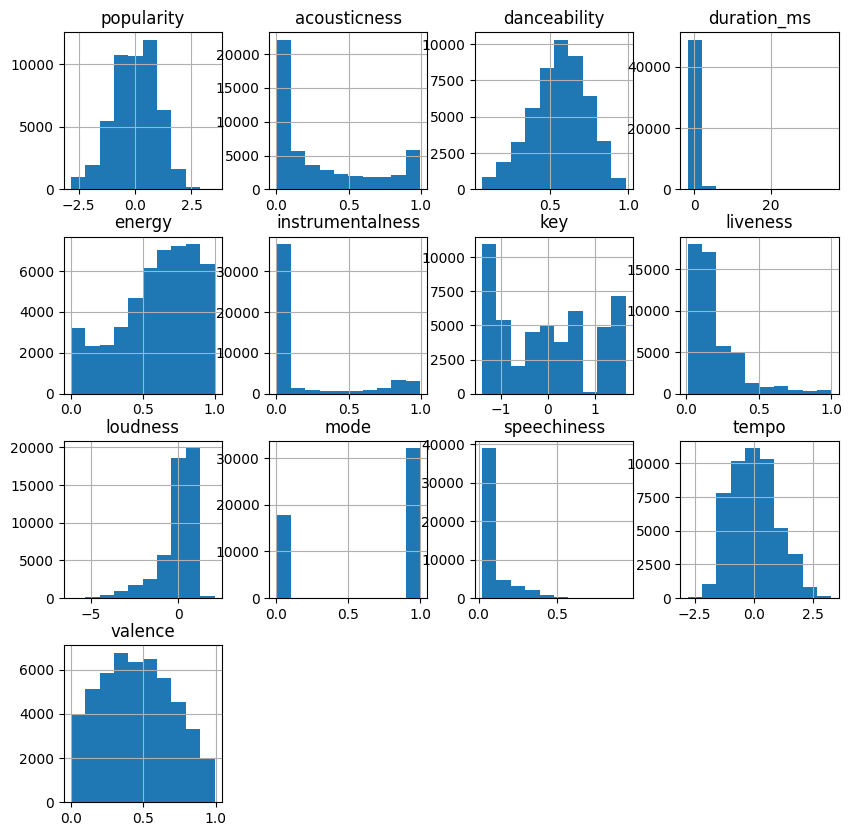

In [21]:
p = train_data.hist(figsize = (10,10))

In [22]:
train_data = train_data.drop(["duration_ms"],axis = 1)

# Pairplot of rescaled clean data

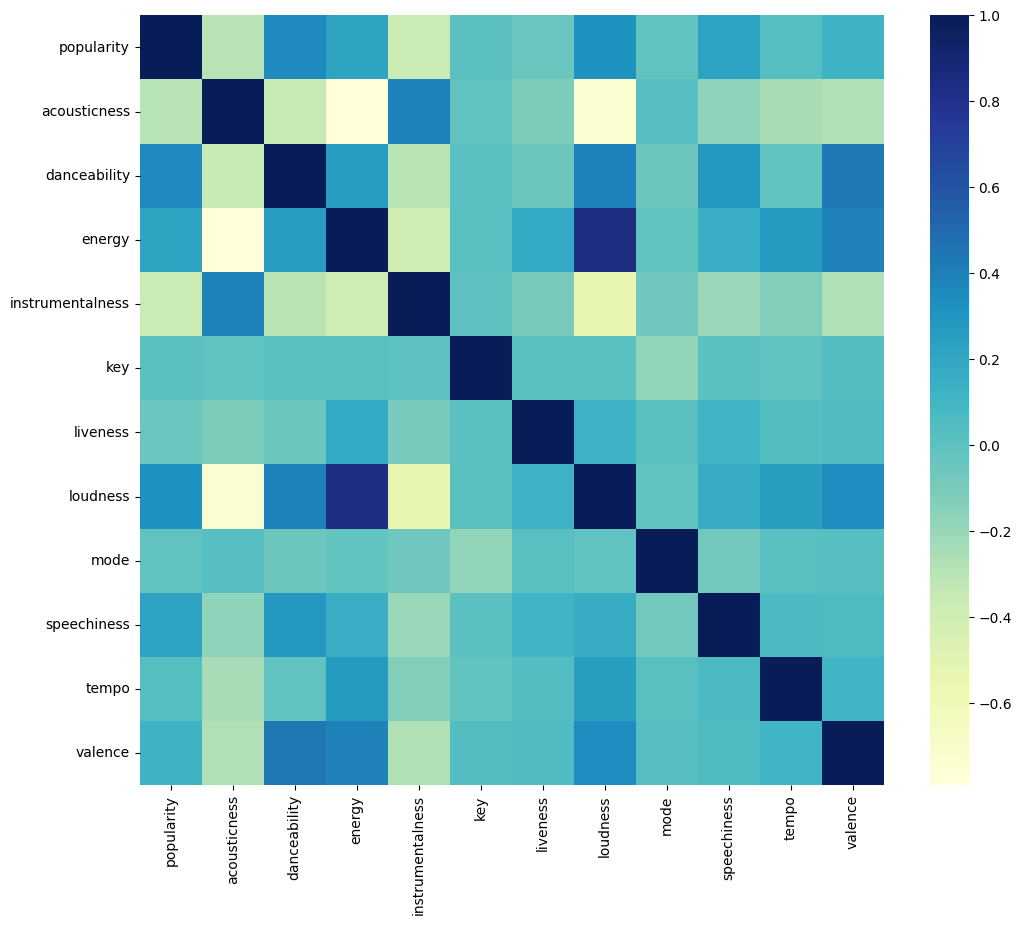

In [23]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (12, 10))
sns.heatmap(train_data.corr(), annot = False, cmap="YlGnBu")
plt.show()

# Clustering

In [24]:
X = train_data.copy()

In [25]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.mixture import GaussianMixture

In [26]:
# elbow plotting
def plot_elbow(data_frame):
    inertia = []
    for n in range(1 , 11):
        # I don't think there's a need to change the n_init, tol and max_tier

        algorithm = (KMeans(n_clusters = n ) )
        algorithm.fit(data_frame)
        inertia.append(algorithm.inertia_)
    plt.figure(1 , figsize = (8 ,4))
    plt.plot(np.arange(1 , 11) , inertia , 'o')
    plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.show()

In [27]:
def plot_silhouette_score(data_frame, rang=11):
    cluster_score = []
    for n in range(2, rang):
        algorithm = (KMeans(n_clusters = n, random_state= 42))
        algorithm.fit(data_frame)
        labels1 = algorithm.labels_
        cluster_score.append(silhouette_score(data_frame, labels1))
    plt.figure(1 , figsize = (8 ,4))
    plt.plot(np.arange(2 , rang) , cluster_score , 'o')
    plt.plot(np.arange(2 , rang) , cluster_score , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Score')
    plt.show()

In [28]:
def plot_silhouette_score_gmm(data_frame):
    cluster_score = []
    for n in range(2, 11):
        algorithm = (GaussianMixture(n_components = n,random_state= 42))
        #algorithm.fit(data_frame)
        labels1 = algorithm.fit_predict(data_frame)
        cluster_score.append(silhouette_score(data_frame, labels1))
    plt.figure(1 , figsize = (8 ,4))
    plt.plot(np.arange(2 , 11) , cluster_score , 'o')
    plt.plot(np.arange(2 , 11) , cluster_score , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Score')
    plt.show()

In [29]:
# Plot Silhouette
def plot_silhouette(data_frame, n):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))

    algorithm = (KMeans(n_clusters = n ,tol=0.1,random_state= 42))
    visualizer = SilhouetteVisualizer(algorithm, colors='yellowbrick', ax=ax)
    visualizer.fit(data_frame)

## Find the best k for clustering

In [30]:
 #plot_elbow(X)

In [31]:
 #plot_silhouette_score(X,11)

In [32]:
 #plot_silhouette_score_gmm(X)

In [33]:
 #plot_silhouette(X,11)

## KMeans
Clustering with k = 2

In [34]:
KMeans_default_2 = (KMeans(n_clusters = 2 ,random_state= 42) ) #clustering model

y_kmeans1 = KMeans_default_2.fit(X)

KMeans_default_2_centroids = y_kmeans1.cluster_centers_ #centroids

KMeans_default_2_labels = pd.DataFrame(y_kmeans1.labels_) #labels

## Gaussian Mixture Model
Clustering with k =3

In [35]:
#GMM_default_2 = (GaussianMixture(n_components = 2 ,random_state= 42)) #clustering model
GMM_default_3 = (GaussianMixture(n_components = 3 ,random_state= 42)) #clustering model

#labels1 = GMM_default_2.fit_predict(X)
labels2 = GMM_default_3.fit_predict(X)

#GMM_default_2_labels = pd.DataFrame(labels1) # labels
GMM_default_3_labels = pd.DataFrame(labels2) #labels

## Clustering with PCA

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [37]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(X)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names) # Data after pca

X_pca.head()

,PC1,PC2
0,0.30484,1.39024
1,0.28815,-0.80924
2,-0.15814,-0.09084
3,-0.35690,-1.25345
4,-0.14399,-0.09369


In [38]:
#p = X.hist(figsize = (10,10))

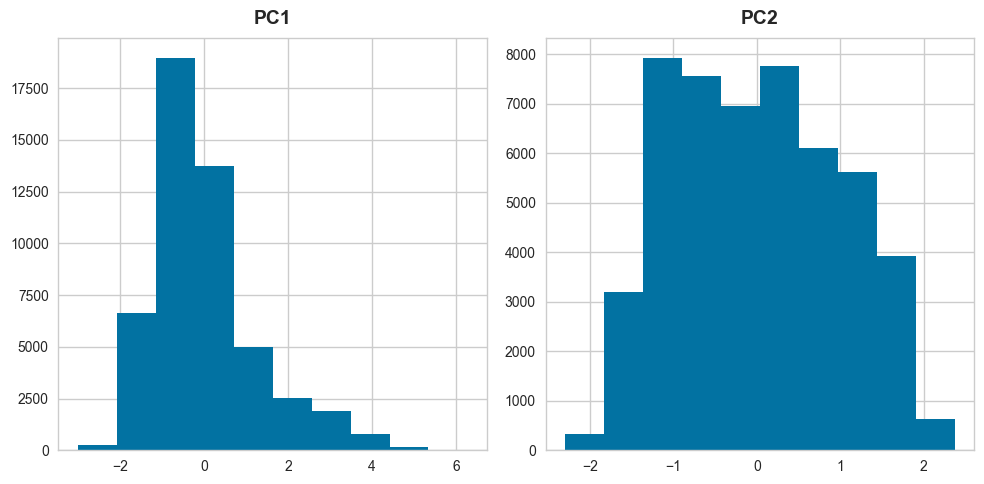

In [39]:
p = X_pca.hist(figsize = (10,5))

In [40]:
#data_pca = X_pca.copy()

### pairplot of PCA components

CPU times: user 713 ms, sys: 3.8 ms, total: 717 ms
Wall time: 254 ms


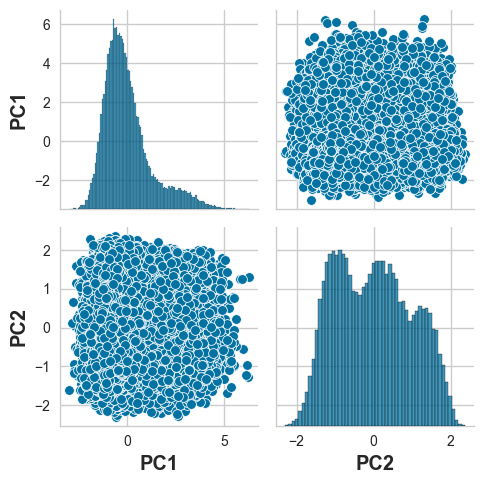

In [41]:
%%time
p=sns.pairplot(X_pca)

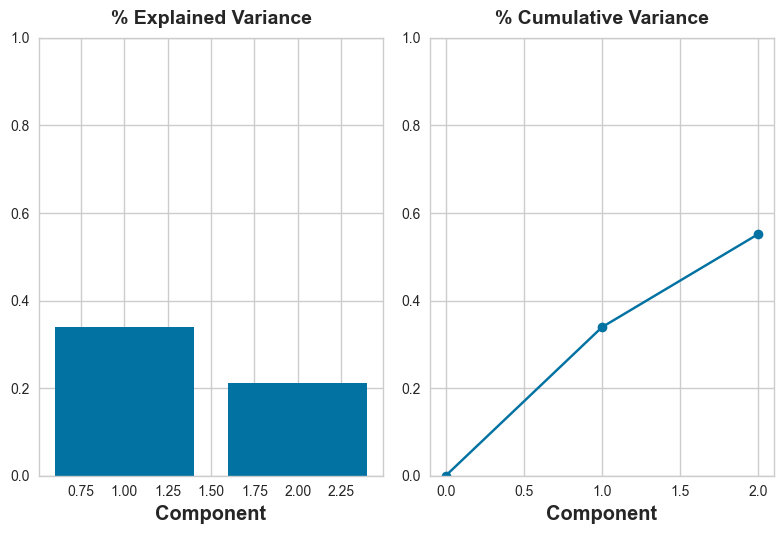

In [42]:
# Look at explained variance
plot_variance(pca);

### Find the best k for clustering with PCA

In [43]:
#plot_elbow(X_pca)

In [44]:
#plot_silhouette_score(X_pca,11)

In [45]:
#plot_silhouette_score_gmm(X_pca)

In [46]:
# plot_silhouette(X_pca,11)

### KMeans
Clustering with k = 3

In [47]:
KMeans_PCA_3 = (KMeans(n_clusters = 3 ,random_state= 42) ) #clustering model

y_kmeans1 = KMeans_PCA_3.fit(X_pca)

KMeans_PCA_3_centroids = y_kmeans1.cluster_centers_ #centroids

KMeans_PCA_3_labels = pd.DataFrame(y_kmeans1.labels_)#labels

visualize = X_pca.copy()
visualize['labels'] = KMeans_PCA_3_labels.copy()

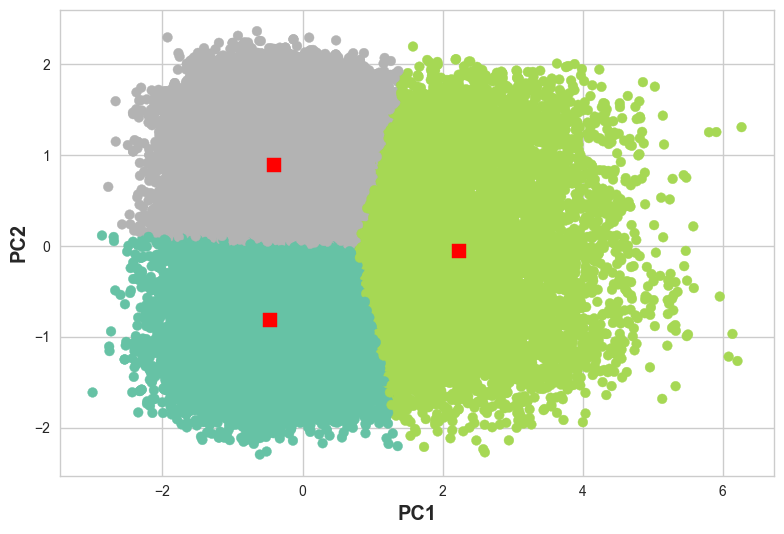

In [48]:
plt.scatter(x=visualize['PC1'],y=visualize['PC2'],c=visualize['labels'],cmap="Set2")
plt.scatter(x = KMeans_PCA_3_centroids[: , 0] , y =  KMeans_PCA_3_centroids[: , 1] , s = 100 , c = 'red' , marker="s")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Gaussian Mixture Model
Clustering with k = 2

In [49]:
GMM_PCA_2 = (GaussianMixture(n_components = 2 ,random_state= 42)) #clustering model

labels1 = GMM_PCA_2.fit_predict(X_pca)

GMM_PCA_2_labels = pd.DataFrame(labels1)

visualize = X_pca.copy()
visualize['labels'] = GMM_PCA_2_labels.copy()

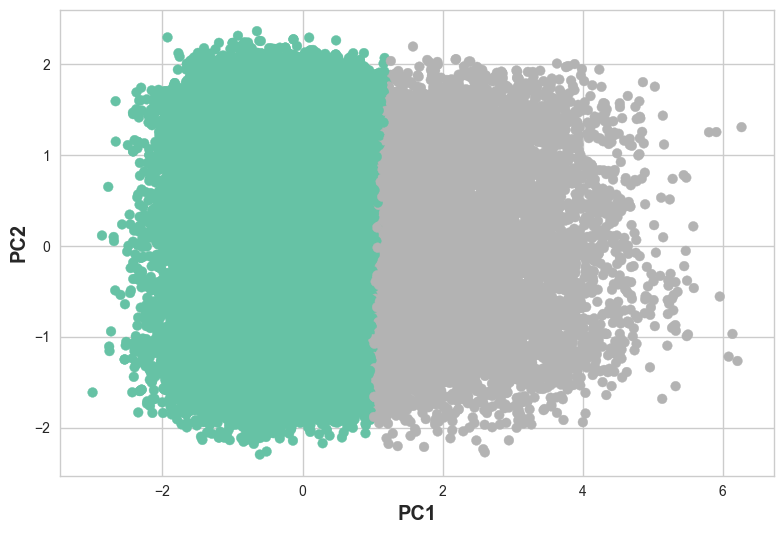

In [50]:
plt.scatter(x=visualize['PC1'],y=visualize['PC2'],c=visualize['labels'],cmap="Set2")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Clustering with ICA

In [51]:
from sklearn.decomposition import FastICA

In [52]:
# Initializing FastICA with n_components=8
ica = FastICA(random_state=42)

# Running the FastICA algorithm using fit_transform on dataset X
ica_result = ica.fit_transform(X)

In [53]:
component_names = [f"IC{i+1}" for i in range(ica_result.shape[1])]
X_ica = pd.DataFrame(ica_result, columns=component_names)

X_ica.head()

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12
0,0.00421,-0.00546,-0.00502,-0.00274,-0.00551,-0.00116,-0.00086,-0.00036,-0.00433,0.01201,-0.00058,0.00380
1,0.00075,0.00489,-0.00436,-0.00199,-0.00590,-0.00020,-0.00321,-0.00231,-0.00150,0.01339,-0.00043,0.00201
2,-0.00298,-0.00106,-0.00147,0.00931,0.00316,0.00420,-0.00355,0.00370,0.00177,0.00041,0.00275,0.00570
3,-0.00432,0.00484,0.00052,-0.00155,0.00321,0.00585,0.00573,0.00345,0.00203,0.00141,0.00108,0.00702
4,-0.00190,-0.00172,0.00343,-0.00052,0.00369,0.00013,-0.00170,0.00277,0.00378,0.01403,0.00674,0.00178


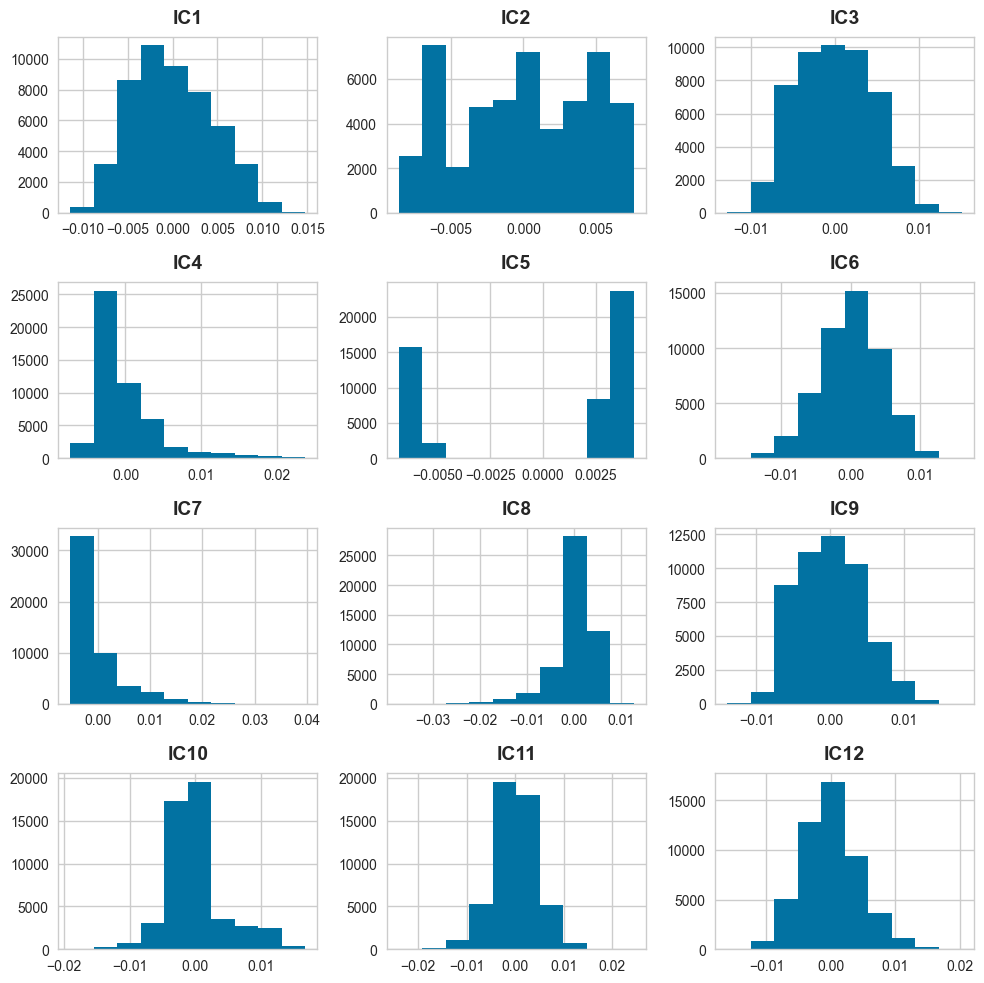

In [54]:
p = X_ica.hist(figsize = (10,10))

### Correlation coefficient heatmap 

In [55]:
"""data_ica = X_ica.copy()
plt.figure(figsize = (12, 10))
sns.heatmap(data_ica.corr(), annot = True, cmap="YlGnBu")"""

'data_ica = X_ica.copy()\nplt.figure(figsize = (12, 10))\nsns.heatmap(data_ica.corr(), annot = True, cmap="YlGnBu")'

### Find the best k for clustering with ICA

In [56]:
#plot_elbow(X_ica)

In [57]:
#plot_silhouette_score(X_ica,11)

In [58]:
#plot_silhouette_score_gmm(X_ica)

In [59]:
# plot_silhouette(X_ica,11)

### KMeans
Clustering with k = 5

In [60]:
KMeans_ICA_5 = (KMeans(n_clusters = 5 ,random_state= 42) ) #clustering model
#KMeans_ICA_7 = (KMeans(n_clusters = 7 ,random_state= 42) ) #clustering model

y_kmeans1 = KMeans_ICA_5.fit(X_ica)
#y_kmeans2 = KMeans_ICA_7.fit(X_ica)

KMeans_ICA_5_centroids = y_kmeans1.cluster_centers_ #centroids
#KMeans_ICA_7_centroids = y_kmeans2.cluster_centers_ #centroids

KMeans_ICA_5_labels = pd.DataFrame(y_kmeans1.labels_) #labels
#KMeans_ICA_7_labels = pd.DataFrame(y_kmeans2.labels_) #labels

### Gaussian Mixture Model
Clustering with k = 2, k = 3 and k = 9

In [61]:
GMM_ICA_2 = (GaussianMixture(n_components = 2 ,random_state= 42)) #clustering model
GMM_ICA_3 = (GaussianMixture(n_components = 3 ,random_state= 42)) #clustering model
GMM_ICA_9 = (GaussianMixture(n_components = 9 ,random_state= 42)) #clustering model

labels1 = GMM_ICA_2.fit_predict(X_ica)
labels2 = GMM_ICA_3.fit_predict(X_ica)
labels3 = GMM_ICA_9.fit_predict(X_ica)

GMM_ICA_2_labels = pd.DataFrame(labels1) # labels
GMM_ICA_3_labels = pd.DataFrame(labels2) # labels
GMM_ICA_9_labels = pd.DataFrame(labels3) # labels

## Building Recommend System

In [62]:
!pip install spotipy

### Define Several Helper Methods

In [79]:
import math

full_track_data = train_data.copy(deep=True)
numeric_data = train_data.copy(deep=True)
info_data = train_data_info.copy(deep=True)
full_track_data = full_track_data.join(info_data)
all_columns = full_track_data.select_dtypes(include=['int64', 'float64']).columns

# Writing methods together

def divide_labels(data_frame, labels):
    data_with_label = data_frame.copy(deep=True)
    data_with_label['label'] = labels
    return data_with_label.groupby('label')


# Function to calculate the Euclidean distance between two points
def euclidean_distance(point1, point2):
  distance = 0
  for i in range(len(point1)):
    distance += (point1[i] - point2[i]) ** 2
  return math.sqrt(distance)

# Calculate the distances between the data points and the center of the cluster
def calculate_mean(df_data_points, df_clusters):
    distances = []
    center = df_clusters.mean()
    for i, data_point in df_data_points.iterrows():
        distance = euclidean_distance(data_point, center)
        distances.append(distance)
        # print(f"Distance between {data_point.values} and center {center.values}: {distance}")
    return distances

def calculate_nearest(df_data_points, df_clusters):
    # Calculate the distances between the data points and the nearest point in the cluster
    distances = []

    center = df_clusters.mean()
    min_distance = float("inf")
    nearest_point = None
    for j, cluster_point in df_clusters.iterrows():
        distance = euclidean_distance(center, cluster_point)
        if distance < min_distance:
            min_distance = distance
            nearest_point = cluster_point
    distances.append(min_distance)
    return distances

def calculate_farthest(df_data_points, df_clusters):
    # Calculate the distances between the data points and the farthest point in the cluster
    distances = []
    center = df_clusters.mean()
    max_distance = 0
    farthest_point = None
    for j, cluster_point in df_clusters.iterrows():
        distance = euclidean_distance(cluster_point, center)
        if distance > max_distance:
            max_distance = distance
            farthest_point = cluster_point
    distances.append(max_distance)
    return distances

def calculate_mean_distance_from_cluster(distances):
    # distances = alg(df_data_points, df_clusters)
    mean_distance = sum(distances) / len(distances)
    return mean_distance

info_col = train_data_info.columns
#print(info_col)

def get_label_and_cluster(alg, data_input, df_data_points, df_labels):
    df_clusters = divide_labels(df_data_points, df_labels)
    # cluster_info = df_clusters[info_col]

    best_label = None
    cluster_group = None
    info_group = None

    isFindFar = False

    if alg == calculate_farthest:
        isFindFar = True

    distances_dict = {}
    group_dict = {}
    info_dict = {}

    for group_name, group in df_clusters:
        #print(group_name, len(group))
        info_group = group[info_col]
        group = group.drop(info_col, axis=1)
        mean_dis = calculate_mean_distance_from_cluster(alg(data_input, group))
        distances_dict[str(group_name)] = mean_dis
        group_dict[str(group_name)] = group
        info_dict[str(group_name)] = info_group
    
    # if isFindFar:
    #     best_label = min(distances_dict, key=lambda k: distances_dict[k])
    #     cluster_group = group_dict[best_label]
    # else:
    #     best_label = min(distances_dict, key=lambda k: distances_dict[k])
    #     cluster_group = group_dict[best_label]

    best_label = min(distances_dict, key=lambda k: distances_dict[k])
    cluster_group = group_dict[best_label]
    info_group = info_dict[best_label]
    
    return best_label, cluster_group, info_group

import spotipy
from scipy.spatial.distance import cdist
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import StandardScaler

# sp = spotipy.Spotify()
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='4b6fd35fe6c64538a58492dc0671ee46',
                                                           client_secret='2c2351fc08c44888b01bd5e2c2c195ed'))

def get_row_from_spotify(track_name, artist):
    song_data = {}
    results = sp.search(q= 'track: {} artist: {}'.format(track_name,artist), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    artist_info = results['artists'][0]
    artist_name = artist_info['name']
    artist_id = artist_info['id']
    artist_info = sp.artist(artist_id)

    # track_json = sp.track(track_id)
    # genre_seeds = sp.recommendation_genre_seeds(seed_tracks = track_id)
    audio_features = sp.audio_features(track_id)[0]

    # song_data['id'] = [track_id]
    # song_data['year'] = [artist]

    possible_genres = ' & '.join(artist_info['genres'])

    song_data['music_genre'] = [possible_genres]
    song_data['track_name'] = [track_name]
    song_data['artist_name'] = [artist_name]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    del song_data['id']
    del song_data['uri']
    del song_data['track_href']
    del song_data['time_signature']
    del song_data['analysis_url']
    del song_data['duration_ms']
    del song_data['type']
    del song_data['explicit']

    song_data = pd.DataFrame(song_data);

    # ==================== scale ================

    # Select only the integer columns in the DataFrame
    int_cols = song_data.select_dtypes(include=["int64"])

    # Convert the data type of the integer columns to float
    song_data[int_cols.columns] = int_cols.astype("float64")
    tmp = song_data[train_data.columns]
    # track_data[train_data.columns] = scaler.fit_transform(track_data[train_data.columns].T).T
    # track_data[train_data.columns].head()

    cols_out_of_range = song_data[train_data.columns].apply(lambda x: x is not str and x.min() < 0 or x.max() > 1)
    # get the column names of the DataFrame as a list
    col_names = train_data.columns.tolist()

    # get a list of columns that have values out of range
    cols_out_of_range_list = [col_name for col_name, out_of_range in zip(col_names, cols_out_of_range) if out_of_range]
    cols_out_of_range_list

    sd_scaler = StandardScaler()
    song_data[cols_out_of_range_list] = sd_scaler.fit_transform(song_data[cols_out_of_range_list].T).T
    # track_data[cols_out_of_range_list].head()
    song_data.head()
    # ===========================================

    return song_data
    # song_data = None
    # try:
    #     song_data = get_row_from_data(track_name, artist)
    # except:
    #     song_data = get_row_from_spotify(track_name, artist)
    # return song_data

def get_mean_vector(song_list):
    song_vectors = []
    
    for song in song_list:
        # number cols are all the columns
        # vector is all song columns data 
        song_vector = song[all_columns].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
    flattened_dict = {}
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict

### Build the recommender class

In [64]:
class Recommender:

    def __init__(self) -> None:
        self.cluster_alg = calculate_mean
        self.distance_alg = 'cosine'
        self.all_data = full_track_data

    # def set_labels(self, data_labels):
    #     self.data_labels = data_labels

    def set_alg(self, cluster_alg, distance_alg):
        self.cluster_alg = cluster_alg
        self.distance_alg = distance_alg

    def set_all_data(self, all_data):
        self.all_data = all_data

    def fit(self, train_data, data_labels):
        self.train_data = train_data
        set_all = set(train_data.columns)
        set_info = set(info_col)
        self.all_columns = list(set_all.difference(set_info))
        self.data_labels = data_labels

    def get_row_from_data(self, track_name, artist):
        matching_rows = self.all_data.loc[
            (self.all_data["track_name"] == track_name) 
            & (self.all_data["artist_name"] == artist)]
        return matching_rows.iloc[[0], :]

    def get_song_data(self, track_name, artist):
        song_data = None
        try:
            song_data = self.get_row_from_data(track_name, artist)
        except:
            song_data = get_row_from_spotify(track_name, artist)
        return song_data

    def get_mean_vector(self, song_list):
        song_vectors = []
        
        for song in song_list:
            # number cols are all the columns
            # vector is all song columns data 
            song_vector = song[self.all_columns].values
            song_vectors.append(song_vector)  
        
        song_matrix = np.array(list(song_vectors))
        return np.mean(song_matrix, axis=0)

    def recommend_songs(self, song_list, n_songs=10):

        song_full_data = []
        for sng in song_list:
            song_data = self.get_song_data(sng['track'], sng['artist'])
            # print(song_data.columns)
            if song_data is None:
                print('Warning: {} does not exist in Spotify or in database'.format(sng['track']))
                continue
            song_full_data.append(song_data)

        # todo: standarize

        df_song = pd.concat(song_full_data)
        df_song = df_song.drop(info_col, axis=1)

        # Select only the integer columns in the DataFrame
        int_cols = df_song.select_dtypes(include=["int64"])

        # Convert the data type of the integer columns to float
        df_song[int_cols.columns] = int_cols.astype("float64")

        label_best, clustered_data, info_group = get_label_and_cluster(self.cluster_alg, df_song, self.train_data, self.data_labels)

        cluster_info_data = clustered_data.copy(deep=True)
        cluster_info_data = cluster_info_data.join(info_group)

        song_flatten = flatten_dict_list(song_list)
        song_center = self.get_mean_vector(song_full_data)
        distances = None

        if self.distance_alg == 'cosine':
            distances = cdist(song_center.reshape(1, -1), clustered_data[self.all_columns], metric='cosine')
        elif self.distance_alg == 'euclidean':
            distances = cdist(song_center.reshape(1, -1), clustered_data[self.all_columns], metric='euclidean')
        elif self.distance_alg == 'manhattan':
            distances = cdist(song_center.reshape(1, -1), clustered_data[self.all_columns], metric='cityblock')


        index = list(np.argsort(distances)[:, :n_songs][0])
        
        rec_songs = cluster_info_data.iloc[index]
        rec_songs = rec_songs[~rec_songs['track_name'].isin(song_flatten['track'])]
        
        return rec_songs[['artist_name', 'track_name', 'music_genre']].to_dict(orient='records')

### Generate Test Data

In [65]:
input_df = full_track_data.sample(n=10)
input_data = []
input_data_with_genre = []
for i, row in input_df.iterrows():
    input_dict = {}
    input_dict['track'] = row['track_name']
    input_dict['artist'] = row['artist_name']
    input_data.append(input_dict)
    tmp = input_dict.copy()
    tmp['genre'] = row['music_genre']
    input_data_with_genre.append(tmp)


### Create a function get Spotify Recommendation

In [66]:
def spotify_recomm(data_list):
    track_seeds = []
    artist_seeds = []

    limit = 5

    for row in data_list:
        track_name = row['track']
        artist_name = row['artist']
        results = sp.search(q= 'track: {} artist: {}'.format(track_name,artist_name), limit=1)
        if results['tracks']['items'] == []:
            return None

        results = results['tracks']['items'][0]
        track_id = results['id']
        artist_info = results['artists'][0]
        artist_id = artist_info['id']
        track_seeds.append(track_id)
        artist_seeds.append(artist_id)
        limit -= 1
        if limit <= 0:
            break

    # print(artist_seeds)
    # print(len(artist_seeds))
    result = sp.recommendations(seed_tracks=track_seeds, limit=10)
    # print(result)
    track_list = result['tracks']
    track_data_list = []
    for spotify_track in track_list:
        track_id = spotify_track['id']
        track_name = spotify_track['name']
        artist_name = spotify_track['artists'][0]['name']
        # print(track_name, artist_name)

        track_data = get_row_from_spotify(track_name, artist_name)
        #print(track_data)
        track_data_list.append(track_data)

    return track_data_list

        

### Test the code

In [67]:
spotify_recomm(input_data)

[  music_genre           track_name artist_name  popularity  danceability  \
 0              That's How It Feels   Soul Clan    -0.13307       0.67400   
 
    energy      key  loudness    mode  speechiness  acousticness  \
 0 0.27400 -0.61416  -0.91594 1.00000      0.09160       0.31100   
 
    instrumentalness  liveness  valence   tempo  
 0           0.00019   0.04490  0.30300 1.66317  ,
                                          music_genre    track_name  \
 0  contemporary country & country & country road ...  Now You Know   
 
     artist_name  popularity  danceability  energy      key  loudness    mode  \
 0  Jon Langston    -0.02523       0.47500 0.93200 -0.72343  -0.88975 1.00000   
 
    speechiness  acousticness  instrumentalness  liveness  valence   tempo  
 0      0.06490       0.02960           0.00000   0.08830  0.52400 1.63840  ,
               music_genre track_name  artist_name  popularity  danceability  \
 0  chill lounge & nu jazz    Catwalk  Alex Cortiz    -0.06408

In [112]:
from scipy.spatial.distance import euclidean, cosine

def measure_diversity(songs,function=euclidean):
    """
    Calculate the pairwise distances between the recommended songs using
    either the Euclidean distance or the cosine distance, and return the
    average distance.
    """
    distances = []
    # iterate over all pairs of songs
    for i in range(len(songs)):
        for j in range(i+1, len(songs)):
            # calculate the distance between the two songs using either
            # the Euclidean distance or the cosine distance
            distance = function(songs[i], songs[j])
            # or: distance = cosine(songs[i], songs[j])
            distances.append(distance)
    # return the average distance
    return sum(distances) / len(distances)

# calculate the Jaccard index for two lists of strings
def input_output_genreCompare(list1, list2):
    # convert the lists to sets of unique elements
    n = 0
    sortedList1 = sorted(list1)
    sortedList2 = sorted(list2)
    for a, b in zip(sortedList1,sortedList2):
        if a == b:
            n += 1
    return n / len(list1)


# calculate the Jaccard index for two lists of strings
def list_compare(list1, list2):
    # convert the lists to sets of unique elements
    n = 0
    sortedList1 = sorted(list1)
    sortedList2 = sorted(list2)
    for a, b in zip(sortedList1,sortedList2):
        if a == b:
            n += 1
    return n / len(list1)

def measure_similarity(song1, song2, function=euclidean):
    """
    Calculate the distance between two songs using either the Euclidean
    distance or the cosine distance, and return the similarity.
    """
    # calculate the distance between the two songs using either
    # the Euclidean distance or the cosine distance
    distance = function(song1, song2)
    # convert the distance to a similarity using the formula:
    # similarity = 1 / (1 + distance)
    similarity = 1 / (1 + distance)
    # return the similarity
    return similarity

def measure_similarity_2d(song1, song2, function=euclidean):
    """
    Wrapper function that calculates the similarity between two songs
    using the measure_similarity function, but handles 2-D input.
    """
    # flatten the 2-D input arrays into 1-D arrays
    song1_flat = [elem for sublist in song1 for elem in sublist]
    song2_flat = [elem for sublist in song2 for elem in sublist]
    # call the measure_similarity function with the flattened 1-D arrays
    similarity = measure_similarity(song1_flat, song2_flat, function=function)
    # return the similarity
    return similarity

In [69]:
input_data_with_genre

[{'track': 'Shake It Loose', 'artist': "Mo' Horizons", 'genre': 'Electronic'},
 {'track': 'Be Quiet and Drive (Far Away)',
  'artist': 'Deftones',
  'genre': 'Rock'},
 {'track': "You've Got My Mind Messed Up",
  'artist': 'James Carr',
  'genre': 'Blues'},
 {'track': "Whatcha Know 'Bout That",
  'artist': 'Morgan Wallen',
  'genre': 'Rock'},
 {'track': "Don't Carry It All", 'artist': 'empty_field', 'genre': 'Rock'},
 {'track': 'Slow Down', 'artist': 'Steve Moakler', 'genre': 'Rock'},
 {'track': 'Kirameki Moonlight', 'artist': 'Rei Yasuda', 'genre': 'Anime'},
 {'track': 'All Night', 'artist': 'Big Boi', 'genre': 'Hip-Hop'},
 {'track': "Driving a Car While Listening to Bill Burr's Podcast",
  'artist': 'dné',
  'genre': 'Electronic'},
 {'track': 'I Put a Spell on You (feat. Joss Stone)',
  'artist': 'Jeff Beck',
  'genre': 'Blues'}]

In [70]:

def getSongRec(data, labels, distFunction):
    rec = Recommender()
    rec.set_all_data(data) # give all data to search for music
    rec.set_alg(calculate_mean, distFunction) # set algorithms
    rec.fit(data, labels) # give train data to find cluster (please remove the input music here)
    SongsRec = rec.recommend_songs(input_data)
    return rec, SongsRec
    #print(SongsRec2)

def getSongRec2(data, data_input, labels, clusFunction=calculate_mean, distFunction='cosine'):
    rec = Recommender()
    rec.set_all_data(data) # give all data to search for music
    rec.set_alg(clusFunction, distFunction) # set algorithms
    rec.fit(data, labels) # give train data to find cluster (please remove the input music here)
    SongsRec = rec.recommend_songs(data_input)
    return rec, SongsRec
    #print(SongsRec2)

def divideTrackArtist(SongsRec):
    track_list = [d['track_name'] for d in SongsRec]
    artist_list = [d['artist_name'] for d in SongsRec]
    return track_list, artist_list

def divideInputTrackArtist(inputSongs):
    track_list = [d['track'] for d in inputSongs]
    artist_list = [d['artist'] for d in inputSongs]
    return track_list, artist_list

def findSongFeatures(track_list,artist_list,recommender):
    Songs_features = []
    for track, artist in zip(track_list, artist_list):
        song_feature = recommender.get_song_data(track,artist)
        # song feature is a data frame
        # print(song_feature.columns)
        song_feature = song_feature.drop(info_col, axis=1)
        Songs_features.append(song_feature)

    Songs_features = pd.concat(Songs_features)

    # Songs_features = pd.DataFrame(Songs_features).values
    return Songs_features.values

In [71]:
PCA_all_data = X_pca.copy(deep=True)
PCA_all_data = PCA_all_data.join(info_data)
ICA_all_data = X_ica.copy(deep=True)
ICA_all_data = ICA_all_data.join(info_data)

def my_pipeline(input_df_n, data_labels, cluster_list, method_list):

    input_data_n = []
    input_data_with_genre_n = []
    for i, row in input_df_n.iterrows():
        input_dict = {}
        input_dict['track'] = row['track_name']
        input_dict['artist'] = row['artist_name']
        input_data_n.append(input_dict)
        tmp = input_dict.copy()
        tmp['genre'] = row['music_genre']
        input_data_with_genre_n.append(tmp)

    data_input = input_data_n
    input_genre = input_data_with_genre_n

    result_list = []

    for row in data_labels:
        data = row['data']
        labels = row['labels']
        name = row['name']
        print('starting pipeline on handling: ', name, '......')
        
        for cluster_fun in cluster_list:
            for met in method_list:
                # output
                rec1, SongsRec1 = getSongRec2(data, data_input, labels, cluster_fun, met)
                track_list1, artist_list1 = divideTrackArtist(SongsRec1)
                SongsRec1_features = findSongFeatures(track_list1,artist_list1,rec1)
                diversity = measure_diversity(SongsRec1_features)
                genreCompare = input_output_genreCompare([d['genre'] for d in input_genre],[d['music_genre'] for d in SongsRec1])
                
                # input
                track_list2, artist_list2 = divideInputTrackArtist(data_input)
                input_features = findSongFeatures(track_list2,artist_list2,rec1)
                er_similarity = measure_similarity_2d(SongsRec1_features, input_features, euclidean)
                co_similarity = measure_similarity_2d(SongsRec1_features, input_features, cosine)

                print('eu ', er_similarity, ' co ', co_similarity, ' div: ', diversity, ' gen: ', genreCompare, ' clu ', cluster_fun.__name__, ' met ', met)

                row_list = []
                row_list.append(name)
                row_list.append(diversity)
                row_list.append(genreCompare)
                row_list.append(er_similarity)
                row_list.append(co_similarity)
                row_list.append(cluster_fun.__name__)
                row_list.append(met)
                result_list.append(row_list)
    return result_list


In [94]:
import csv

total_result = []

for i in range(0, 15):
    input_df_n = full_track_data.sample(n=10)
    
    data_label_list = []
    data_label_list.append({'data': PCA_all_data, 'labels': KMeans_PCA_3_labels, 'name':'KMeans_PCA_3'})
    data_label_list.append({'data': PCA_all_data, 'labels': GMM_PCA_2_labels, 'name':'GMM_PCA_2'})
    data_label_list.append({'data': ICA_all_data, 'labels': GMM_ICA_3_labels, 'name':'GMM_ICA_3'})
    data_label_list.append({'data': ICA_all_data, 'labels': GMM_ICA_9_labels, 'name':'GMM_ICA_9'})
    data_label_list.append({'data': ICA_all_data, 'labels': KMeans_ICA_5_labels, 'name':'KMeans_ICA_5'})
    data_label_list.append({'data': full_track_data, 'labels': KMeans_default_2_labels, 'name':'KMeans_Default_2'})
    data_label_list.append({'data': full_track_data, 'labels': GMM_default_3_labels, 'name':'GMM_Default_3'})

    fun_list_1 = [calculate_mean, calculate_nearest, calculate_farthest]
    fun_list_2 = ['euclidean', 'cosine', 'manhattan']


    # print('Pipeline ', i + 1, ' started: ')
    # result = my_pipeline(input_df_n, data_label_list, fun_list_1, fun_list_2)

    try:
        print('Pipeline ', i + 1, ' started: ')
        result = my_pipeline(input_df_n, data_label_list, fun_list_1, fun_list_2)
        total_result += result
    except:
        print('Pipeline ', i + 1, ' error ')
        continue

# total_result

current_time = time.time()

with open('output/output' + str(int(current_time)) + '.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name', 'diversity', 'genre_compate', 'euclidean_similarity', 'cosine_similarity', 'cluster_method_name', 'distance_method_name'])
    for row_result in total_result:
        writer.writerow(row_result)


Pipeline  1  started: 
starting pipeline on handling:  KMeans_PCA_3 ......
eu  0.1520671988449447  co  0.5367372257684283  div:  0.021328460226871442  gen:  0.2  clu  calculate_mean  met  euclidean
eu  0.13513700698958744  co  0.5194257644717634  div:  0.5462875335343182  gen:  0.1  clu  calculate_mean  met  cosine
eu  0.15213990824429602  co  0.537744053386694  div:  0.02403537293498212  gen:  0.2  clu  calculate_mean  met  manhattan
eu  0.1520671988449447  co  0.5367372257684283  div:  0.021328460226871442  gen:  0.2  clu  calculate_nearest  met  euclidean
eu  0.13513700698958744  co  0.5194257644717634  div:  0.5462875335343182  gen:  0.1  clu  calculate_nearest  met  cosine
eu  0.15213990824429602  co  0.537744053386694  div:  0.02403537293498212  gen:  0.2  clu  calculate_nearest  met  manhattan
eu  0.15451302135724135  co  0.567339844613614  div:  0.23410804564962476  gen:  0.3  clu  calculate_farthest  met  euclidean
eu  0.11571717976535584  co  0.5183359116130447  div:  0.26447

In [73]:

# current_time = time.time()

# with open('output/output' + str(int(current_time)) + '.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(['name', 'diversity', 'genre_compate', 'euclidean_similarity', 'cosine_similarity', 'cluster_method_name', 'distance_method_name'])
#     for row_result in total_result:
#         writer.writerow(row_result)

In [74]:
# run every thing in pipeline, below deprecated

In [95]:
pd_output = pd.read_csv('output/output1670769386.csv')
df_output = pd.DataFrame(pd_output)

In [96]:
df_output.describe()

,diversity,genre_compate,euclidean_similarity,cosine_similarity
count,756.00000,756.00000,756.00000,756.00000
mean,0.28916,0.26706,0.49381,0.59605
std,0.35206,0.16816,0.39451,0.06759
min,0.00432,0.00000,0.09594,0.41001
25%,0.00925,0.10000,0.13849,0.54320
50%,0.02428,0.30000,0.19679,0.58080
75%,0.59327,0.40000,0.94799,0.65189
max,1.34844,0.70000,0.96064,0.79180


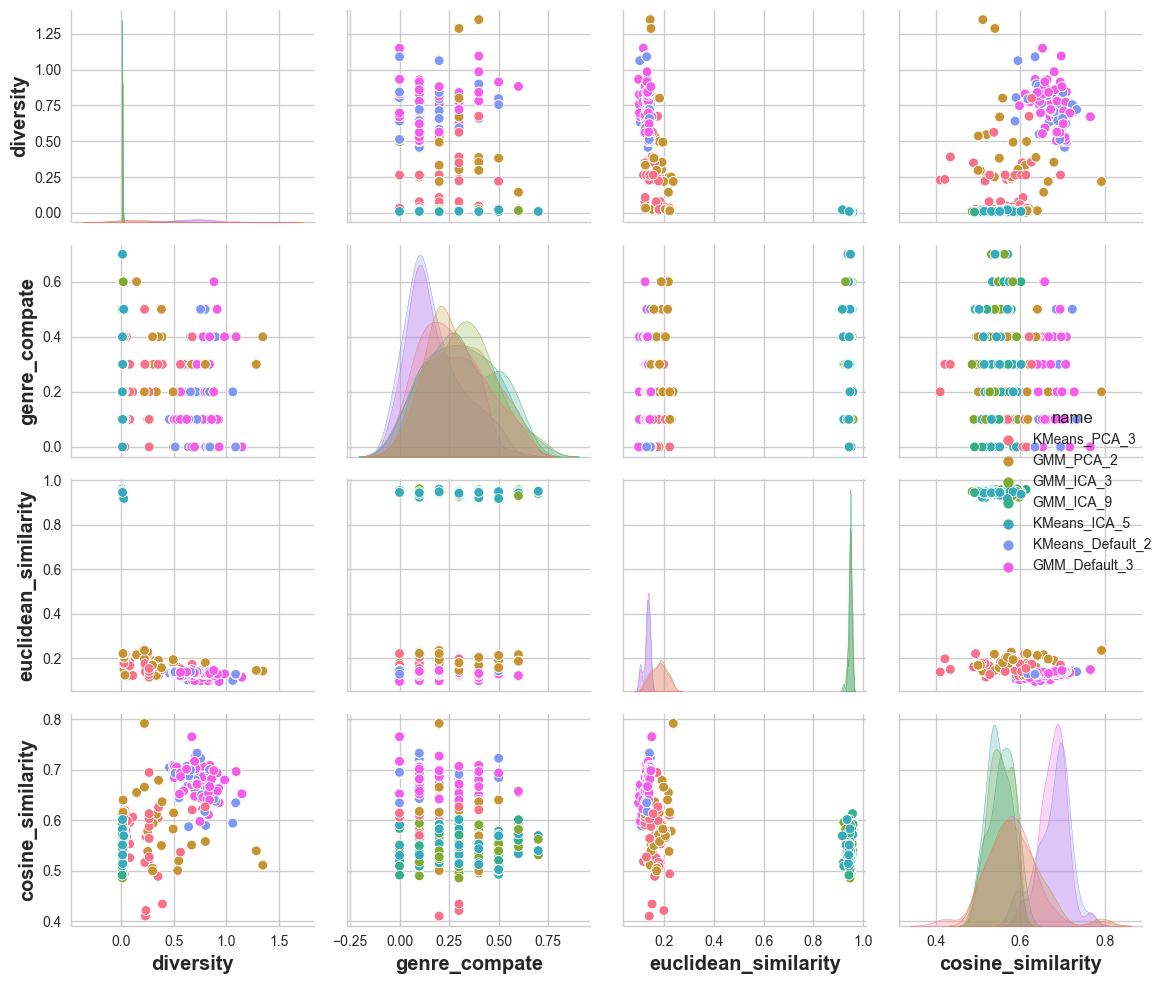

In [97]:

sns.pairplot(df_output, hue='name')

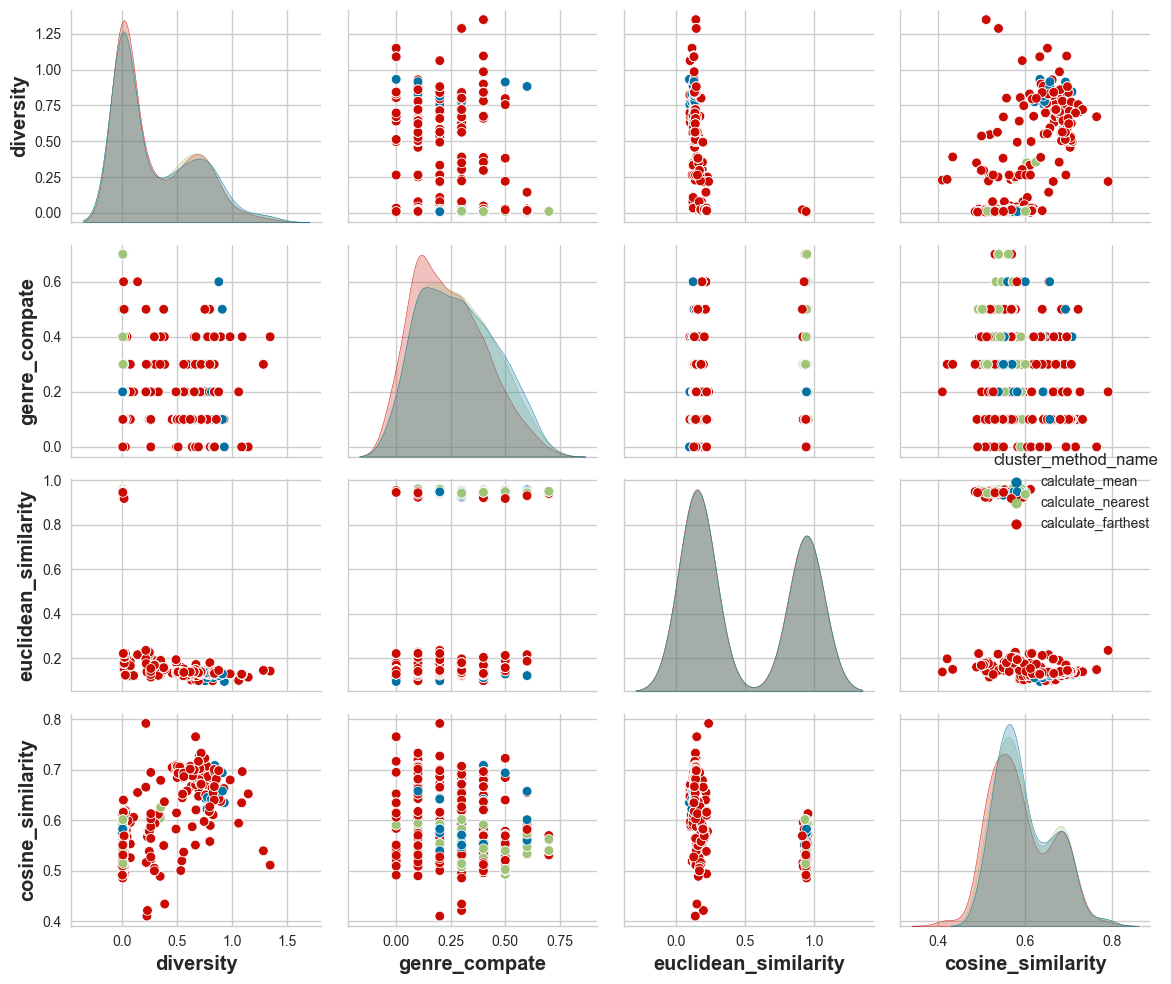

In [98]:

sns.pairplot(df_output, hue='cluster_method_name')

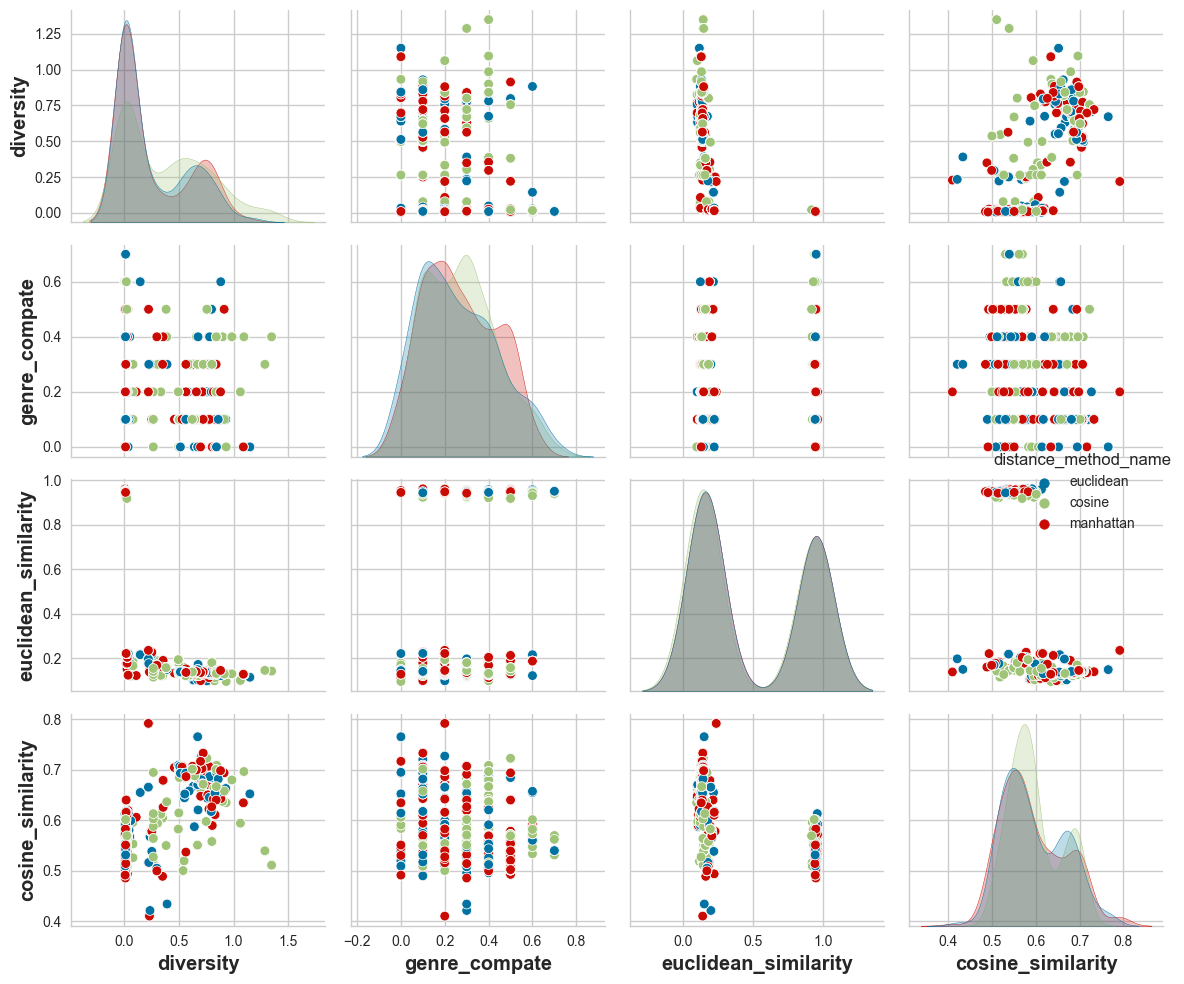

In [99]:

sns.pairplot(df_output, hue='distance_method_name')

In [156]:

from plotly import optional_imports
import plotly.express as px 

# group_pairs = df_output.groupby(['name', 'distance_method_name', 'cluster_method_name'])
group_pairs = df_output.groupby(['name'])
group_mean = group_pairs.mean()
# for index, row in group_mean.iterrows():
#     print(row)

fig = px.bar(group_mean, x=group_mean.index, y=['diversity', 'genre_compate', 'euclidean_similarity', 'cosine_similarity'], barmode='group')
fig.show()

In [155]:

# group_pairs = df_output.groupby(['name', 'distance_method_name', 'cluster_method_name'])
group_pairs = df_output.groupby(['distance_method_name'])
group_mean = group_pairs.mean()

fig = px.bar(group_mean, x=group_mean.index, y=['diversity', 'genre_compate', 'euclidean_similarity', 'cosine_similarity'], barmode='group')
fig.show()

In [157]:
group_pairs = df_output.groupby(['cluster_method_name'])
group_mean = group_pairs.mean()

fig = px.bar(group_mean, x=group_mean.index, y=['diversity', 'genre_compate', 'euclidean_similarity', 'cosine_similarity'], barmode='group')
fig.show()

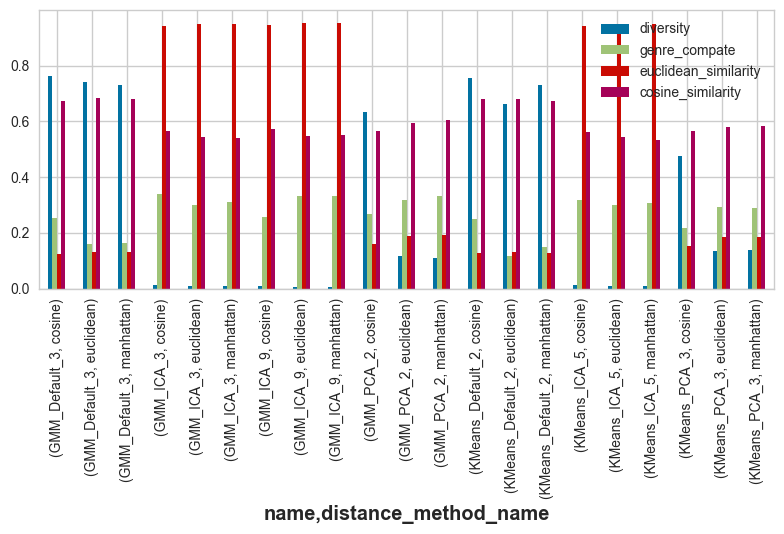

In [161]:
group_pairs = df_output.groupby(['name', 'distance_method_name'])
# group_pairs = df_output.groupby(['name'])
group_mean = group_pairs.mean()

ax = group_mean.plot(kind='bar')
plt.show()

In [131]:
def my_pipeline_sp(input_df_n, data_labels, cluster_list, method_list):
    input_data_n = []
    for i, row in input_df_n.iterrows():
        input_dict = {}
        input_dict['track'] = row['track_name']
        input_dict['artist'] = row['artist_name']
        input_data_n.append(input_dict)

    data_input = input_data_n

    result_list = []

    for row in data_labels:
        data = row['data']
        labels = row['labels']
        name = row['name']
        print('starting pipeline on handling: ', name, '......')
        
        for cluster_fun in cluster_list:
            for met in method_list:
                # output
                rec_sp, SongsRec_sp = getSongRec2(data, data_input, labels, cluster_fun, met)

                track_list_test, artist_list_test = divideTrackArtist(SongsRec_sp)
                SongsRec_features_test = findSongFeatures(track_list_test,artist_list_test,rec_sp)

                # input
                track_list2, artist_list2 = divideInputTrackArtist(data_input)
                input_features = findSongFeatures(track_list2,artist_list2,rec_sp)

                # spotify output
                spotify_track_list = spotify_recomm(input_data)
                df_spotify_track = pd.concat(spotify_track_list)
                df_spotify_tmp = df_spotify_track.drop(info_col, axis=1)
                df_spotify_tmp.values
                diversity_sp = measure_diversity(df_spotify_tmp.values)
                
                # list things
                row_list = []
                row_list.append(name)
                row_list.append(cluster_fun.__name__)
                row_list.append(met)
                
                diversity = measure_diversity(SongsRec_features_test)
                print(diversity, diversity_sp)
                row_list.append(diversity)
                row_list.append(diversity_sp)

                track_name_compare = list_compare([row['track_name'].values for row in spotify_track_list],[d['track_name'] for d in SongsRec_sp])
                print(track_name_compare)
                row_list.append(track_name_compare)

                track_artist_compare = list_compare([row['artist_name'].values for row in spotify_track_list],[d['artist_name'] for d in SongsRec_sp])
                print(track_artist_compare)
                row_list.append(track_artist_compare)

                # input
                track_list_sp_2, artist_list_sp_2 = divideInputTrackArtist(input_data)
                input_features = findSongFeatures(track_list_sp_2,artist_list_sp_2,rec_sp)
                er_similarity = measure_similarity_2d(SongsRec_features_test, input_features, euclidean)
                co_similarity = measure_similarity_2d(SongsRec_features_test, input_features, cosine)

                print(er_similarity, ' ', co_similarity)
                row_list.append(er_similarity) # my vs input
                row_list.append(co_similarity)

                er_similarity = measure_similarity_2d(df_spotify_tmp.values, input_features, euclidean)
                co_similarity = measure_similarity_2d(df_spotify_tmp.values, input_features, cosine)

                print(er_similarity, ' ', co_similarity)
                row_list.append(er_similarity) # spotify vs input
                row_list.append(co_similarity) 

                er_similarity = measure_similarity_2d(df_spotify_tmp.values, SongsRec_features_test, euclidean)
                co_similarity = measure_similarity_2d(df_spotify_tmp.values, SongsRec_features_test, cosine)

                print(er_similarity, ' ', co_similarity)
                row_list.append(er_similarity) # my vs spotify
                row_list.append(co_similarity)
                result_list.append(row_list)
    return result_list

In [132]:
total_result_sp = []

for i in range(0, 5):
    input_df_n = full_track_data.sample(n=10)
    
    data_label_list = []
    data_label_list.append({'data': full_track_data, 'labels': KMeans_default_2_labels, 'name':'KMeans_Default_2'})
    data_label_list.append({'data': full_track_data, 'labels': GMM_default_3_labels, 'name':'GMM_Default_3'})

    fun_list_1 = [calculate_mean, calculate_nearest, calculate_farthest]
    fun_list_2 = ['euclidean', 'cosine', 'manhattan']


    # print('Pipeline ', i + 1, ' started: ')
    # result = my_pipeline(input_df_n, data_label_list, fun_list_1, fun_list_2)

    try:
        print('Pipeline ', i + 1, ' started: ')
        result = my_pipeline_sp(input_df_n, data_label_list, fun_list_1, fun_list_2)
        total_result_sp += result
    except:
        print('Pipeline ', i + 1, ' error ')
        continue

# total_result

current_time = time.time()

with open('output/output_sp_' + str(int(current_time)) + '.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name', 'cluster_function', 'distance_function', 'my_diversity', 'spotify_diversity', 'name_match', 'artist_match', 'my_euclidean_similarity', 'my_cosine_similarity', 'spotify_euclidean_similarity', 'spotify_cosine_similarity', 'compare_euclidean_similarity', 'compare_cosine_similarity'])
    for row_result in total_result_sp:
        writer.writerow(row_result)


Pipeline  1  started: 
starting pipeline on handling:  KMeans_Default_2 ......
0.7076867277651544 1.0552819219651328
0.0
0.0
0.12204992334718537   0.612970508434868
0.09458746801160428   0.5658653065916448
0.10033060099945013   0.53671136763757
0.7441503441035021 1.3704336925412324
0.0
0.0
0.12361911408288903   0.6388835143910113
0.09714324728190593   0.5747522192413991
0.10133743355086458   0.5557400562114676
0.730872002719027 1.258528527282529
0.0
0.0
0.12630948928750982   0.6338055344707362
0.09848518939497597   0.570726749629628
0.10407757882282602   0.5341078985776136
0.7076867277651544 1.57673492085736
0.0
0.0
0.12204992334718537   0.612970508434868
0.09733978855572532   0.5721896259348738
0.10493863771119762   0.5505057002982239
0.7441503441035021 1.4235287157947236
0.0
0.0
0.12361911408288903   0.6388835143910113
0.09925544446075951   0.5726130411116407
0.10489314527168546   0.5574615364521636
0.730872002719027 1.3719187870755634
0.0
0.0
0.12630948928750982   0.6338055344707362

In [167]:
pd_sp_recomm = pd.read_csv('output/output_sp_1670777309.csv')
df_sp_recomm = pd.DataFrame(pd_sp_recomm)

In [168]:
df_sp_recomm.columns

Index(['name', 'cluster_function', 'distance_function', 'my_diversity',
       'spotify_diversity', 'name_match', 'artist_match',
       'my_euclidean_similarity', 'my_cosine_similarity',
       'spotify_euclidean_similarity', 'spotify_cosine_similarity',
       'compare_euclidean_similarity', 'compare_cosine_similarity'],
      dtype='object')

In [183]:
# group_pairs = df_output.groupby(['name', 'distance_method_name'])
group_cols = ['name']
group_pairs = df_sp_recomm.groupby(group_cols)
group_mean = group_pairs.mean()

other_cols = df_sp_recomm.columns.tolist()
other_cols.remove('name')
other_cols.remove('cluster_function')
other_cols.remove('distance_function')
group_mean

fig = px.bar(group_mean, x=group_mean.index, y=other_cols, barmode='group')
fig.show()

In [185]:
# group_pairs = df_output.groupby(['name', 'distance_method_name'])
group_cols = ['distance_function']
group_pairs = df_sp_recomm.groupby(group_cols)
group_mean = group_pairs.mean()

other_cols = df_sp_recomm.columns.tolist()
other_cols.remove('name')
other_cols.remove('cluster_function')
other_cols.remove('distance_function')
group_mean

fig = px.bar(group_mean, x=group_mean.index, y=other_cols, barmode='group')
fig.show()

In [186]:
# group_pairs = df_output.groupby(['name', 'distance_method_name'])
group_cols = ['cluster_function']
group_pairs = df_sp_recomm.groupby(group_cols)
group_mean = group_pairs.mean()

other_cols = df_sp_recomm.columns.tolist()
other_cols.remove('name')
other_cols.remove('cluster_function')
other_cols.remove('distance_function')
group_mean

fig = px.bar(group_mean, x=group_mean.index, y=other_cols, barmode='group')
fig.show()